# Features engineer

In [5]:
import pandas as pd

# === 檔案路徑 ===
TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

# === 讀取資料 ===
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_val   = pd.read_csv(VAL_PATH, sep="\t")

# === 建立 binary 標籤 ===
df_train["gex_binary"] = (df_train["gex"] > 0.0).astype(int)
df_val["gex_binary"]   = (df_val["gex"] > 0.0).astype(int)

# === 統計數量與比例 ===
def summarize_binary(df, name):
    counts = df["gex_binary"].value_counts().sort_index()
    total = counts.sum()
    print(f"\n📊 {name} dataset summary")
    print(f"Total samples: {total}")
    print(f"Class 0 (gex == 0.0): {counts.get(0, 0)} ({counts.get(0, 0)/total:.2%})")
    print(f"Class 1 (gex > 0.0): {counts.get(1, 0)} ({counts.get(1, 0)/total:.2%})")

summarize_binary(df_train, "TRAIN (X1)")
summarize_binary(df_val, "VALID (X2)")



📊 TRAIN (X1) dataset summary
Total samples: 16284
Class 0 (gex == 0.0): 9448 (58.02%)
Class 1 (gex > 0.0): 6836 (41.98%)

📊 VALID (X2) dataset summary
Total samples: 16284
Class 0 (gex == 0.0): 8078 (49.61%)
Class 1 (gex > 0.0): 8206 (50.39%)


In [11]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

# ============================================================
#                  CONFIGURATION
# ============================================================
TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]

# 🟩 改動：我們現在要分類 gex == 0.0 vs > 0.0
TARGET_COL = "gex_binary"

# Chromosomes (autosomes 2–22)
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

# 🟩 新增：轉成二元分類標籤
df_train_full[TARGET_COL] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_COL]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_COL]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  LIGHTGBM PARAMETERS (分類版)
# ============================================================
params = {
    "objective": "binary",        # 🟩 改成二分類
    "metric": ["auc", "binary_logloss"],
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "deterministic": True,
    "force_row_wise": True,
}

# ============================================================
#                  CROSS-CHROMOSOME TRAINING
# ============================================================
results = []

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Val chromosomes: {val_chrs}")
    
    # -----------------------------
    # Split by chromosome
    # -----------------------------
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    # -----------------------------
    # Prepare X, y
    # -----------------------------
    X_train, y_train = df_train[feature_cols], df_train[TARGET_COL]
    X_val, y_val     = df_val[feature_cols], df_val[TARGET_COL]

    # -----------------------------
    # LightGBM Dataset
    # -----------------------------
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # -----------------------------
    # Train model
    # -----------------------------
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    # -----------------------------
    # Predictions
    # -----------------------------
    df_val["pred_prob"] = model.predict(X_val, num_iteration=model.best_iteration)
    df_val["pred_label"] = (df_val["pred_prob"] >= 0.4).astype(int)

    # -----------------------------
    # Evaluate Metrics
    # -----------------------------
    auc = roc_auc_score(y_val, df_val["pred_prob"])
    acc = accuracy_score(y_val, df_val["pred_label"])
    f1  = f1_score(y_val, df_val["pred_label"])
    cm  = confusion_matrix(y_val, df_val["pred_label"])

    print(f"\n📈 Fold {fold_idx+1} Results:")
    print(f"   AUC = {auc:.4f}, ACC = {acc:.4f}, F1 = {f1:.4f}")
    print(f"   Confusion matrix:\n{cm}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "auc": auc,
        "acc": acc,
        "f1": f1
    })

# ============================================================
#                  SUMMARY
# ============================================================
summary_fold = pd.DataFrame(results)
print("\n===== Cross-Chromosome Fold Summary =====")
print(summary_fold)
print(f"\nMean AUC: {summary_fold['auc'].mean():.4f}")
print(f"Mean ACC: {summary_fold['acc'].mean():.4f}")
print(f"Mean F1 : {summary_fold['f1'].mean():.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Feature count: 672

🚀 Fold 1 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.999979	train's binary_logloss: 0.0605642	val's auc: 0.911971	val's binary_logloss: 0.376432
Early stopping, best iteration is:
[125]	train's auc: 0.998679	train's binary_logloss: 0.111224	val's auc: 0.914974	val's binary_logloss: 0.370134

📈 Fold 1 Results:
   AUC = 0.9150, ACC = 0.8281, F1 = 0.8304
   Confusion matrix:
[[1890  490]
 [ 308 1953]]

🚀 Fold 2 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	train's auc: 0.992212	train's binary_log

🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Feature count: 672

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
🧠 Training Binary Classifier...
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.973869	val's auc: 0.913847
[400]	train's auc: 0.988369	val's auc: 0.915801
Early stopping, best iteration is:
[360]	train's auc: 0.986012	val's auc: 0.916357
📈 Binary Classifier: AUC=0.9164, ACC=0.8388, F1=0.8276
🧩 Training Regression Model...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.117407	val's rmse: 0.171759
[400]	train's rmse: 0.10776	val's rmse: 0.169357
Early stopping, best iteration is:
[438]	train's rmse: 0.106855	val's rmse: 0.16902

🚀 Fold 2 | Validation chro

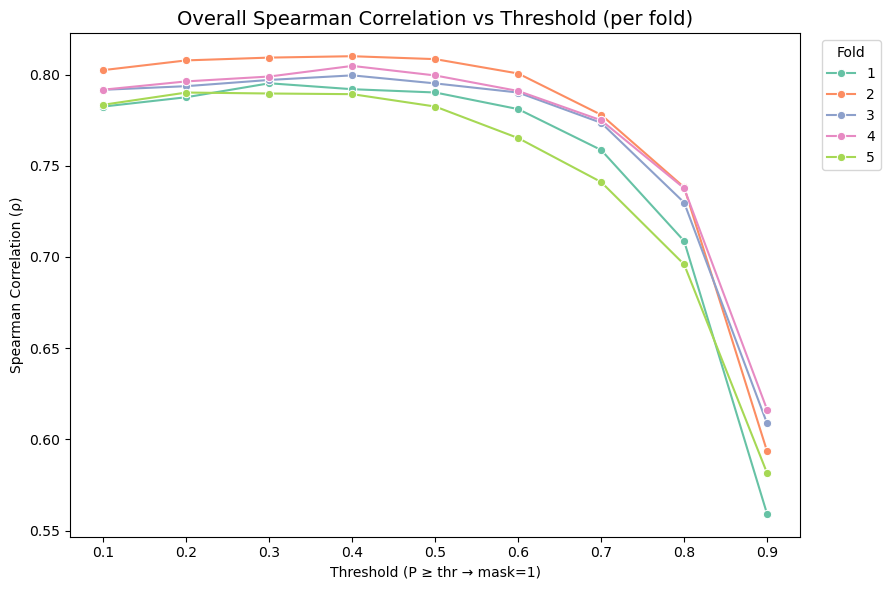

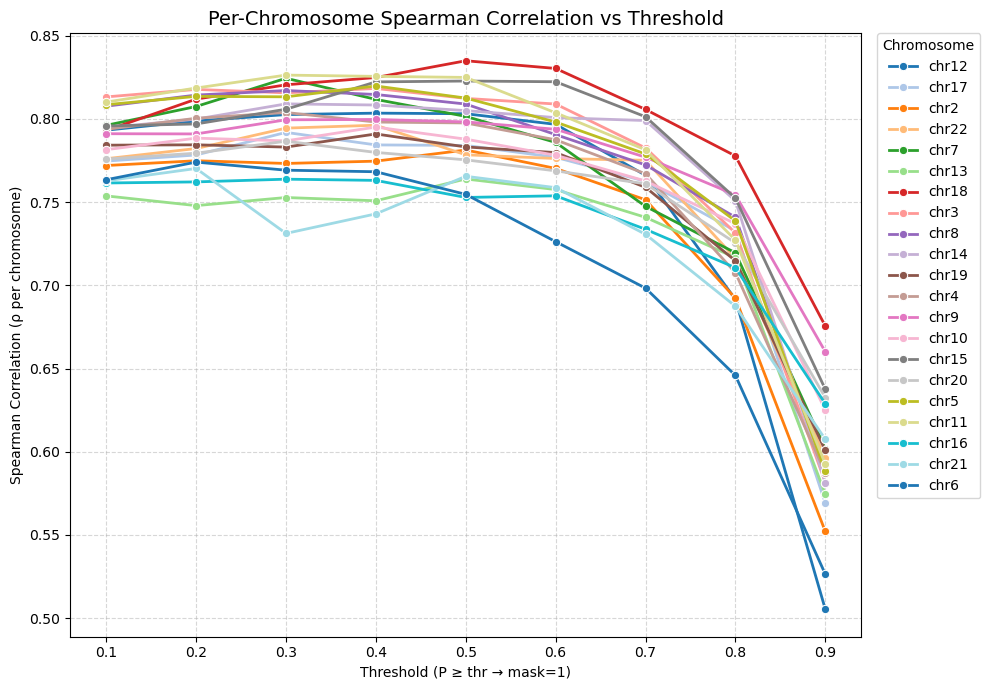

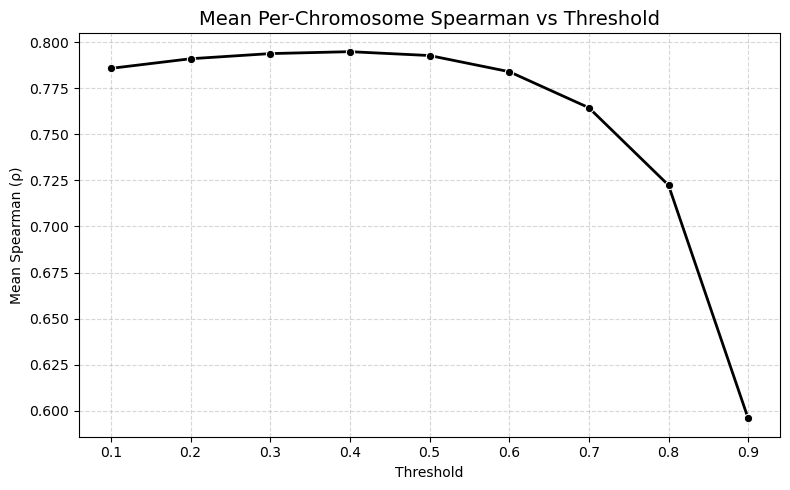


🌟 Best threshold = 0.40 with mean per-chr Spearman ρ = 0.7949


In [22]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

# Binary labels
df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_BINARY]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL CONFIGS
# ============================================================

params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.016676974956976915,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.64561553423692,
    "bagging_fraction": 0.8113835038425429,
    "bagging_freq": 6,
    "lambda_l1": 0.3316673054635859,
    "lambda_l2": 0.8969317795206216,
    "min_gain_to_split": 0.04923442843722911,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

params_reg = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.016676974956976915,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.64561553423692,
    "bagging_fraction": 0.8113835038425429,
    "bagging_freq": 6,
    "lambda_l1": 0.3316673054635859,
    "lambda_l2": 0.8969317795206216,
    "min_gain_to_split": 0.04923442843722911,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

# ============================================================
# CROSS-CHROMOSOME TRAINING + THRESHOLD SWEEP
# ============================================================
results = []
threshold_records = []
chr_rho_records = []
thresholds = np.arange(0.1, 1.0, 0.1)

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Validation chromosomes: {val_chrs}")

    # Split data by chromosome
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    X_train, y_train_bin, y_train_reg = (
        df_train[feature_cols],
        df_train[TARGET_BINARY],
        df_train[TARGET_RANK],
    )
    X_val, y_val_bin, y_val_reg = (
        df_val[feature_cols],
        df_val[TARGET_BINARY],
        df_val[TARGET_RANK],
    )

    # =======================================================
    # 1️⃣ Train Binary Classifier
    # =======================================================
    print("🧠 Training Binary Classifier...")
    dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
    dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)

    model_bin = lgb.train(
        params_bin,
        dtrain_bin,
        valid_sets=[dtrain_bin, dval_bin],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_prob"] = model_bin.predict(X_val, num_iteration=model_bin.best_iteration)

    auc = roc_auc_score(y_val_bin, df_val["pred_prob"])
    acc = accuracy_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    f1  = f1_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    print(f"📈 Binary Classifier: AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}")

    # =======================================================
    # 2️⃣ Train Regression Model
    # =======================================================
    print("🧩 Training Regression Model...")
    dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
    dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)

    model_reg = lgb.train(
        params_reg,
        dtrain_reg,
        valid_sets=[dtrain_reg, dval_reg],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_reg"] = model_reg.predict(X_val, num_iteration=model_reg.best_iteration)

    # =======================================================
    # 3️⃣ Threshold Sweep (0.1–0.9)
    # =======================================================
    for thr in thresholds:
        df_val["pred_masked_thr"] = df_val["pred_reg"] * (df_val["pred_prob"] >= thr).astype(int)

        # 🔹 Overall correlation
        rho_thr = spearmanr(df_val[TARGET_RANK], df_val["pred_masked_thr"])[0]
        threshold_records.append({
            "fold": fold_idx + 1,
            "threshold": thr,
            "rho": rho_thr
        })

        # 🔹 Per-chromosome correlation
        for chrom, subdf in df_val.groupby("chr"):
            if len(subdf) < 2:
                continue
            rho_chr = spearmanr(subdf[TARGET_RANK], subdf["pred_masked_thr"])[0]
            chr_rho_records.append({
                "fold": fold_idx + 1,
                "chr": chrom,
                "threshold": thr,
                "rho_chr": rho_chr
            })

    # =======================================================
    # 4️⃣ Baseline comparisons
    # =======================================================
    rho_reg = spearmanr(df_val[TARGET_RANK], df_val["pred_reg"])[0]
    rho_weighted = spearmanr(df_val[TARGET_RANK], df_val["pred_reg"] * df_val["pred_prob"])[0]

    results.append({
        "fold": fold_idx + 1,
        "auc": auc,
        "acc": acc,
        "f1": f1,
        "rho_reg": rho_reg,
        "rho_weighted": rho_weighted,
    })

# ============================================================
# SUMMARY
# ============================================================
summary = pd.DataFrame(results)
thr_df = pd.DataFrame(threshold_records)
chr_df = pd.DataFrame(chr_rho_records)

print("\n===== Cross-Chromosome Summary =====")
print(summary[["fold", "auc", "acc", "f1", "rho_reg", "rho_weighted"]])

print(f"\nMean AUC = {summary['auc'].mean():.4f}")
print(f"Mean ACC = {summary['acc'].mean():.4f}")
print(f"Mean F1  = {summary['f1'].mean():.4f}")
print(f"Mean ρ (reg)      = {summary['rho_reg'].mean():.4f}")
print(f"Mean ρ (weighted) = {summary['rho_weighted'].mean():.4f}")

# ============================================================
# 📊 Visualization 1: Spearman vs Threshold (overall)
# ============================================================
plt.figure(figsize=(9, 6))
sns.lineplot(data=thr_df, x="threshold", y="rho", hue="fold", marker="o", palette="Set2")
plt.title("Overall Spearman Correlation vs Threshold (per fold)", fontsize=14)
plt.xlabel("Threshold (P ≥ thr → mask=1)")
plt.ylabel("Spearman Correlation (ρ)")
plt.legend(title="Fold", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ============================================================
# 📊 Visualization 2: Per-chromosome Spearman vs Threshold
# ============================================================
plt.figure(figsize=(10, 7))
sns.lineplot(
    data=chr_df,
    x="threshold",
    y="rho_chr",
    hue="chr",
    marker="o",
    palette="tab20",
    linewidth=2,
)

plt.title("Per-Chromosome Spearman Correlation vs Threshold", fontsize=14)
plt.xlabel("Threshold (P ≥ thr → mask=1)")
plt.ylabel("Spearman Correlation (ρ per chromosome)")
plt.grid(True, linestyle="--", alpha=0.5)

# 📘 顯示圖例，放在右邊、垂直排列
plt.legend(
    title="Chromosome",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    ncol=1,           # 單欄
    fontsize=10,
)

plt.tight_layout()
plt.show()


# ============================================================
# 📊 Visualization 3: Mean per-chromosome Spearman
# ============================================================
chr_mean = chr_df.groupby("threshold", as_index=False)["rho_chr"].mean()
plt.figure(figsize=(8, 5))
sns.lineplot(data=chr_mean, x="threshold", y="rho_chr", marker="o", color="black", linewidth=2)
plt.title("Mean Per-Chromosome Spearman vs Threshold", fontsize=14)
plt.xlabel("Threshold")
plt.ylabel("Mean Spearman (ρ)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

best_thr = chr_mean.loc[chr_mean["rho_chr"].idxmax()]
print(f"\n🌟 Best threshold = {best_thr['threshold']:.2f} with mean per-chr Spearman ρ = {best_thr['rho_chr']:.4f}")


🔒 Global seed set to 42
🧩 Chromosome folds:
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']
Feature count: 672

🚀 Fold 1 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
🧠 Training Binary Classifier...
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.97457	val's auc: 0.912006
[400]	train's auc: 0.989748	val's auc: 0.915324
[600]	train's auc: 0.99741	val's auc: 0.915636
Early stopping, best iteration is:
[587]	train's auc: 0.997143	val's auc: 0.916056
📈 Binary Classifier: AUC=0.9161, ACC=0.8395, F1=0.8292
🧩 Training Regression Model...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.115796	val's rmse: 0.175466
[400]	train's rmse: 0.106702	val's rmse: 0.172827
Early stopping, best iteration is:
[488]	train's rmse: 0.104943	

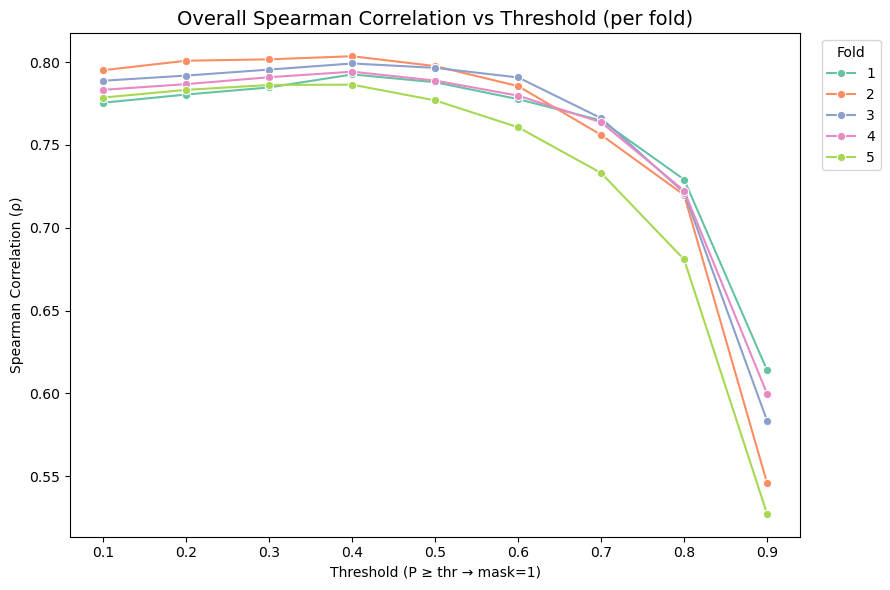

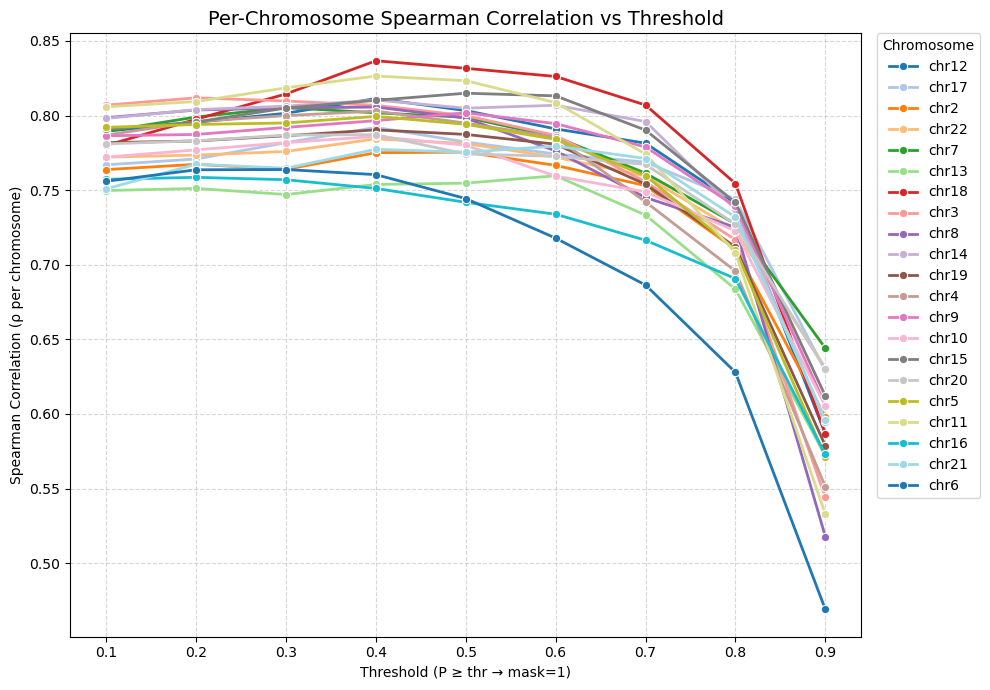

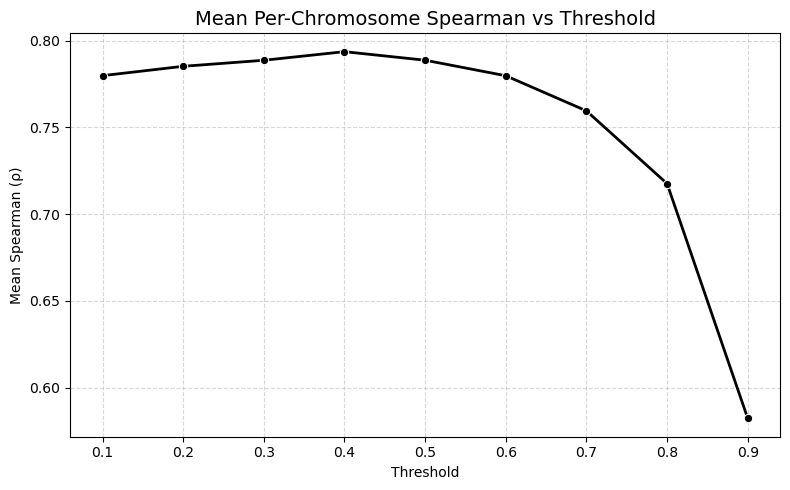


🌟 Best threshold = 0.40 with mean per-chr Spearman ρ = 0.7937


In [21]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_250_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_250_one_side/X2_all_logzscore_logzscore_with_y.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

# Binary labels
df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_BINARY]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL CONFIGS
# ============================================================

params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.016676974956976915,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.64561553423692,
    "bagging_fraction": 0.8113835038425429,
    "bagging_freq": 6,
    "lambda_l1": 0.3316673054635859,
    "lambda_l2": 0.8969317795206216,
    "min_gain_to_split": 0.04923442843722911,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

params_reg = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.016676974956976915,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.64561553423692,
    "bagging_fraction": 0.8113835038425429,
    "bagging_freq": 6,
    "lambda_l1": 0.3316673054635859,
    "lambda_l2": 0.8969317795206216,
    "min_gain_to_split": 0.04923442843722911,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

# ============================================================
# CROSS-CHROMOSOME TRAINING + THRESHOLD SWEEP
# ============================================================
results = []
threshold_records = []
chr_rho_records = []
thresholds = np.arange(0.1, 1.0, 0.1)

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🚀 Fold {fold_idx+1} | Validation chromosomes: {val_chrs}")

    # Split data by chromosome
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    X_train, y_train_bin, y_train_reg = (
        df_train[feature_cols],
        df_train[TARGET_BINARY],
        df_train[TARGET_RANK],
    )
    X_val, y_val_bin, y_val_reg = (
        df_val[feature_cols],
        df_val[TARGET_BINARY],
        df_val[TARGET_RANK],
    )

    # =======================================================
    # 1️⃣ Train Binary Classifier
    # =======================================================
    print("🧠 Training Binary Classifier...")
    dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
    dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)

    model_bin = lgb.train(
        params_bin,
        dtrain_bin,
        valid_sets=[dtrain_bin, dval_bin],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_prob"] = model_bin.predict(X_val, num_iteration=model_bin.best_iteration)

    auc = roc_auc_score(y_val_bin, df_val["pred_prob"])
    acc = accuracy_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    f1  = f1_score(y_val_bin, (df_val["pred_prob"] >= 0.5))
    print(f"📈 Binary Classifier: AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}")

    # =======================================================
    # 2️⃣ Train Regression Model
    # =======================================================
    print("🧩 Training Regression Model...")
    dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
    dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)

    model_reg = lgb.train(
        params_reg,
        dtrain_reg,
        valid_sets=[dtrain_reg, dval_reg],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_reg"] = model_reg.predict(X_val, num_iteration=model_reg.best_iteration)

    # =======================================================
    # 3️⃣ Threshold Sweep (0.1–0.9)
    # =======================================================
    for thr in thresholds:
        df_val["pred_masked_thr"] = df_val["pred_reg"] * (df_val["pred_prob"] >= thr).astype(int)

        # 🔹 Overall correlation
        rho_thr = spearmanr(df_val[TARGET_RANK], df_val["pred_masked_thr"])[0]
        threshold_records.append({
            "fold": fold_idx + 1,
            "threshold": thr,
            "rho": rho_thr
        })

        # 🔹 Per-chromosome correlation
        for chrom, subdf in df_val.groupby("chr"):
            if len(subdf) < 2:
                continue
            rho_chr = spearmanr(subdf[TARGET_RANK], subdf["pred_masked_thr"])[0]
            chr_rho_records.append({
                "fold": fold_idx + 1,
                "chr": chrom,
                "threshold": thr,
                "rho_chr": rho_chr
            })

    # =======================================================
    # 4️⃣ Baseline comparisons
    # =======================================================
    rho_reg = spearmanr(df_val[TARGET_RANK], df_val["pred_reg"])[0]
    rho_weighted = spearmanr(df_val[TARGET_RANK], df_val["pred_reg"] * df_val["pred_prob"])[0]

    results.append({
        "fold": fold_idx + 1,
        "auc": auc,
        "acc": acc,
        "f1": f1,
        "rho_reg": rho_reg,
        "rho_weighted": rho_weighted,
    })

# ============================================================
# SUMMARY
# ============================================================
summary = pd.DataFrame(results)
thr_df = pd.DataFrame(threshold_records)
chr_df = pd.DataFrame(chr_rho_records)

print("\n===== Cross-Chromosome Summary =====")
print(summary[["fold", "auc", "acc", "f1", "rho_reg", "rho_weighted"]])

print(f"\nMean AUC = {summary['auc'].mean():.4f}")
print(f"Mean ACC = {summary['acc'].mean():.4f}")
print(f"Mean F1  = {summary['f1'].mean():.4f}")
print(f"Mean ρ (reg)      = {summary['rho_reg'].mean():.4f}")
print(f"Mean ρ (weighted) = {summary['rho_weighted'].mean():.4f}")

# ============================================================
# 📊 Visualization 1: Spearman vs Threshold (overall)
# ============================================================
plt.figure(figsize=(9, 6))
sns.lineplot(data=thr_df, x="threshold", y="rho", hue="fold", marker="o", palette="Set2")
plt.title("Overall Spearman Correlation vs Threshold (per fold)", fontsize=14)
plt.xlabel("Threshold (P ≥ thr → mask=1)")
plt.ylabel("Spearman Correlation (ρ)")
plt.legend(title="Fold", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ============================================================
# 📊 Visualization 2: Per-chromosome Spearman vs Threshold
# ============================================================
plt.figure(figsize=(10, 7))
sns.lineplot(
    data=chr_df,
    x="threshold",
    y="rho_chr",
    hue="chr",
    marker="o",
    palette="tab20",
    linewidth=2,
)

plt.title("Per-Chromosome Spearman Correlation vs Threshold", fontsize=14)
plt.xlabel("Threshold (P ≥ thr → mask=1)")
plt.ylabel("Spearman Correlation (ρ per chromosome)")
plt.grid(True, linestyle="--", alpha=0.5)

# 📘 顯示圖例，放在右邊、垂直排列
plt.legend(
    title="Chromosome",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    ncol=1,           # 單欄
    fontsize=10,
)

plt.tight_layout()
plt.show()


# ============================================================
# 📊 Visualization 3: Mean per-chromosome Spearman
# ============================================================
chr_mean = chr_df.groupby("threshold", as_index=False)["rho_chr"].mean()
plt.figure(figsize=(8, 5))
sns.lineplot(data=chr_mean, x="threshold", y="rho_chr", marker="o", color="black", linewidth=2)
plt.title("Mean Per-Chromosome Spearman vs Threshold", fontsize=14)
plt.xlabel("Threshold")
plt.ylabel("Mean Spearman (ρ)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

best_thr = chr_mean.loc[chr_mean["rho_chr"].idxmax()]
print(f"\n🌟 Best threshold = {best_thr['threshold']:.2f} with mean per-chr Spearman ρ = {best_thr['rho_chr']:.4f}")


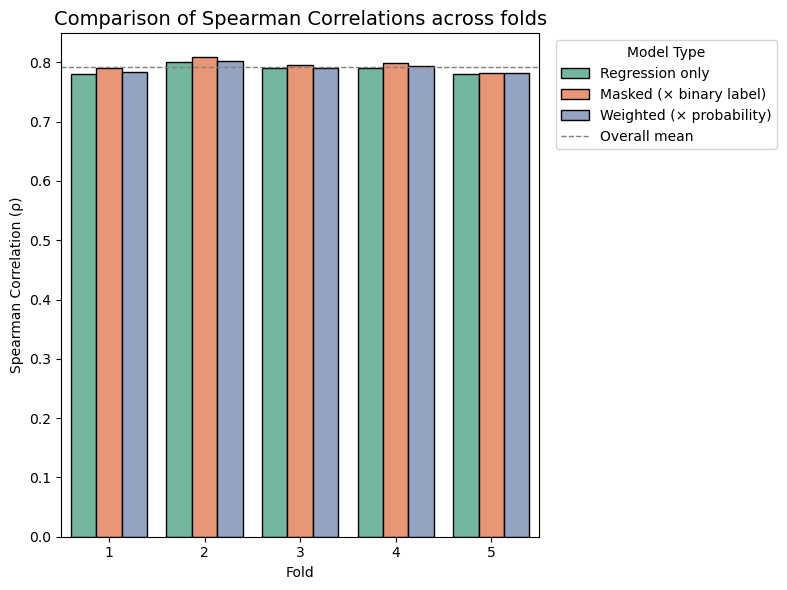

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📊 Visualize Spearman Correlations (ρ)
# ============================================================
plt.figure(figsize=(8, 6))

# melt for grouped barplot
df_plot = summary.melt(
    id_vars="fold",
    value_vars=["rho_reg", "rho_masked", "rho_weighted"],
    var_name="Model",
    value_name="Spearman_ρ"
)

# nice label rename
rename_map = {
    "rho_reg": "Regression only",
    "rho_masked": "Masked (× binary label)",
    "rho_weighted": "Weighted (× probability)"
}
df_plot["Model"] = df_plot["Model"].map(rename_map)

# --- barplot per fold ---
sns.barplot(
    data=df_plot,
    x="fold",
    y="Spearman_ρ",
    hue="Model",
    palette="Set2",
    edgecolor="black"
)

# --- aesthetics ---
plt.axhline(df_plot["Spearman_ρ"].mean(), color="gray", linestyle="--", lw=1, label="Overall mean")
plt.title("Comparison of Spearman Correlations across folds", fontsize=14)
plt.xlabel("Fold")
plt.ylabel("Spearman Correlation (ρ)")
plt.legend(title="Model Type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]

print("🧩 Chromosome folds:")
for i, fset in enumerate(folds):
    print(f"Fold {i+1}: {fset}")

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

# Binary labels
df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_BINARY]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL CONFIGS
# ============================================================

# Binary classifier
params_bin = {
        "objective": "binary",
        "metric": ["auc"],
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": SEED,
}

# Regression model
params_reg = {
        "boosting_type": "gbdt",
        "learning_rate": 0.016676974956976915,
        "num_leaves": 48,
        "max_depth": 8,
        "feature_fraction": 0.64561553423692,
        "bagging_fraction": 0.8113835038425429,
        "bagging_freq": 6,
        "lambda_l1": 0.3316673054635859,
        "lambda_l2": 0.8969317795206216,
        "min_gain_to_split": 0.04923442843722911,
        "min_data_in_leaf": 38,
        "verbose": -1,
        "seed": SEED,
    }

# ============================================================
# CROSS-CHROMOSOME TRAINING
# ============================================================
results = []

thresholds = np.arange(0.1, 1.0, 0.1)
rho_records = []

print("\n===== Threshold Sweep for Masked Spearman =====")

for fold_idx, val_chrs in enumerate(folds):
    print(f"\n🔹 Fold {fold_idx+1}: {val_chrs}")

    # 重新取 validation 資料
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_val = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()
    # Split data by chromosome
    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()

    X_train, y_train_bin, y_train_reg = (
        df_train[feature_cols],
        df_train[TARGET_BINARY],
        df_train[TARGET_RANK],
    )
    X_val, y_val_bin, y_val_reg = (
        df_val[feature_cols],
        df_val[TARGET_BINARY],
        df_val[TARGET_RANK],
    )

    # =======================================================
    # 1️⃣ Train Binary Classifier
    # =======================================================
    print("🧠 Training Binary Classifier...")
    dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
    dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)

    model_bin = lgb.train(
        params_bin,
        dtrain_bin,
        valid_sets=[dtrain_bin, dval_bin],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_prob"] = model_bin.predict(X_val, num_iteration=model_bin.best_iteration)
    df_val["pred_label"] = (df_val["pred_prob"] >= 0.5).astype(int)

    auc = roc_auc_score(y_val_bin, df_val["pred_prob"])
    acc = accuracy_score(y_val_bin, df_val["pred_label"])
    f1  = f1_score(y_val_bin, df_val["pred_label"])
    print(f"📈 Binary Classifier: AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}")

    # =======================================================
    # 2️⃣ Train Regression Model
    # =======================================================
    print("🧩 Training Regression Model...")
    dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
    dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)

    model_reg = lgb.train(
        params_reg,
        dtrain_reg,
        valid_sets=[dtrain_reg, dval_reg],
        valid_names=["train", "val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ],
    )

    df_val["pred_reg"] = model_reg.predict(X_val, num_iteration=model_reg.best_iteration)

    # =======================================================
    # 3️⃣ Combine Predictions
    # =======================================================
    df_val["pred_masked"] = df_val["pred_reg"] * df_val["pred_label"]
    df_val["pred_weighted"] = df_val["pred_reg"] * df_val["pred_prob"]

    # =======================================================
    # 4️⃣ Evaluate Spearman Correlations
    # =======================================================
    rho_reg = spearmanr(df_val[TARGET_RANK], df_val["pred_reg"])[0]
    rho_masked = spearmanr(df_val[TARGET_RANK], df_val["pred_masked"])[0]
    rho_weighted = spearmanr(df_val[TARGET_RANK], df_val["pred_weighted"])[0]

    print(f"\n📊 Spearman Correlations:")
    print(f"   Regression only:  ρ = {rho_reg:.4f}")
    print(f"   Masked product:   ρ = {rho_masked:.4f}")
    print(f"   Weighted product: ρ = {rho_weighted:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "auc": auc,
        "acc": acc,
        "f1": f1,
        "rho_reg": rho_reg,
        "rho_masked": rho_masked,
        "rho_weighted": rho_weighted
    })
    

# ============================================================
# SUMMARY
# ============================================================
summary = pd.DataFrame(results)
print("\n===== Cross-Chromosome Summary =====")
print(summary[["fold", "auc", "acc", "f1", "rho_reg", "rho_masked", "rho_weighted"]])

print(f"\nMean AUC = {summary['auc'].mean():.4f}")
print(f"Mean ACC = {summary['acc'].mean():.4f}")
print(f"Mean F1  = {summary['f1'].mean():.4f}")
print(f"Mean ρ (reg)      = {summary['rho_reg'].mean():.4f}")
print(f"Mean ρ (masked)   = {summary['rho_masked'].mean():.4f}")
print(f"Mean ρ (weighted) = {summary['rho_weighted'].mean():.4f}")


In [26]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import KFold

# ============================================================
# GLOBAL CONFIG
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
print(f"🔒 Global seed set to {SEED}")

TRAIN_PATH = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X1_all_logzscore_logzscore_with_y.tsv"
VAL_PATH   = "../preprocessed_data/reference/1. merged data/with_y_500_one_side/X2_all_logzscore_logzscore_with_y.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_RANK = "gex_rank"
TARGET_BINARY = "gex_binary"

chromosomes = [f"chr{i}" for i in range(2, 23)]
N_INNER_FOLDS = 5
MASK_THRESHOLD = 0.4

# ============================================================
# LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")

df_train_full[TARGET_BINARY] = (df_train_full["gex"] > 0.0).astype(int)
df_val_full[TARGET_BINARY]   = (df_val_full["gex"] > 0.0).astype(int)

feature_cols = [c for c in df_train_full.columns if c not in META_COLS + [TARGET_BINARY]]
print(f"Feature count: {len(feature_cols)}")

# ============================================================
# MODEL PARAMS
# ============================================================
params_bin = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.0167,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.81,
    "bagging_freq": 6,
    "lambda_l1": 0.33,
    "lambda_l2": 0.89,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

params_reg = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.0167,
    "num_leaves": 48,
    "max_depth": 8,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.81,
    "bagging_freq": 6,
    "lambda_l1": 0.33,
    "lambda_l2": 0.89,
    "min_data_in_leaf": 38,
    "verbose": -1,
    "seed": SEED,
}

# ============================================================
# MAIN LOOP: LEAVE-ONE-CHROMOSOME
# ============================================================
results = []

for val_chr in chromosomes:
    print(f"\n🚀 Leave-one-chromosome: {val_chr}")

    # Split outer folds
    df_train = df_train_full[df_train_full["chr"] != val_chr].copy()
    df_test  = df_val_full[df_val_full["chr"] == val_chr].copy()

    # Containers for inner folds
    preds_reg = []
    preds_prob = []

    # --- Inner chromosome folds ---
    inner_chrs = [c for c in chromosomes if c != val_chr]
    kf = KFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=SEED)

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(inner_chrs)):
        inner_train_chrs = [inner_chrs[i] for i in train_idx]
        inner_val_chrs   = [inner_chrs[i] for i in val_idx]

        df_inner_train = df_train[df_train["chr"].isin(inner_train_chrs)]
        df_inner_val   = df_train[df_train["chr"].isin(inner_val_chrs)]

        # --- Prepare data ---
        X_train, y_train_bin, y_train_reg = (
            df_inner_train[feature_cols],
            df_inner_train[TARGET_BINARY],
            df_inner_train[TARGET_RANK],
        )
        X_val, y_val_bin, y_val_reg = (
            df_inner_val[feature_cols],
            df_inner_val[TARGET_BINARY],
            df_inner_val[TARGET_RANK],
        )


        # --- Train binary model ---
        dtrain_bin = lgb.Dataset(X_train, label=y_train_bin)
        dval_bin   = lgb.Dataset(X_val, label=y_val_bin, reference=dtrain_bin)

        model_bin = lgb.train(
                params_bin,
                dtrain_bin,
                valid_sets=[dtrain_bin, dval_bin],
                valid_names=["train", "val"],
                num_boost_round=2000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=200)
                ],
            )
        # --- Train regression model ---

        dtrain_reg = lgb.Dataset(X_train, label=y_train_reg)
        dval_reg   = lgb.Dataset(X_val, label=y_val_reg, reference=dtrain_reg)
        model_reg = lgb.train(
            params_reg,
            dtrain_reg,
            valid_sets=[dtrain_reg, dval_reg],
            valid_names=["train", "val"],
            num_boost_round=2000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=200)
            ],
        )
        # --- Predict on held-out test chromosome ---
        X_test = df_test[feature_cols]
        preds_prob.append(model_bin.predict(X_test))
        preds_reg.append(model_reg.predict(X_test))

    # Stack predictions
    preds_prob = np.array(preds_prob)
    preds_reg = np.array(preds_reg)

    # --- Combine methods ---
    mean_prob = preds_prob.mean(axis=0)
    mean_reg = preds_reg.mean(axis=0)

    # 1️⃣ Mean-mask
    mask_mean = (mean_prob >= MASK_THRESHOLD).astype(int)
    pred_mean_masked = mean_reg * mask_mean

    # 2️⃣ All-mask
    mask_all = np.prod((preds_prob >= MASK_THRESHOLD).astype(int), axis=0)
    pred_all_masked = mean_reg * mask_all

    # 3️⃣ No-mask
    pred_nomask = mean_reg

    # --- Evaluate Spearman ---
    rho_mean = spearmanr(df_test[TARGET_RANK], pred_mean_masked)[0]
    rho_all  = spearmanr(df_test[TARGET_RANK], pred_all_masked)[0]
    rho_none = spearmanr(df_test[TARGET_RANK], pred_nomask)[0]

    results.append({
        "chr": val_chr,
        "rho_mean": rho_mean,
        "rho_all": rho_all,
        "rho_none": rho_none,
    })

    print(f"   Mean-mask ρ={rho_mean:.4f} | All-mask ρ={rho_all:.4f} | No-mask ρ={rho_none:.4f}")

# ============================================================
# SUMMARY
# ============================================================
results_df = pd.DataFrame(results)
print("\n===== Per-Chromosome Results =====")
print(results_df)

print(f"\nAverage ρ (Mean-mask): {results_df['rho_mean'].mean():.4f}")
print(f"Average ρ (All-mask):  {results_df['rho_all'].mean():.4f}")
print(f"Average ρ (No-mask):   {results_df['rho_none'].mean():.4f}")


🔒 Global seed set to 42
Feature count: 672

🚀 Leave-one-chromosome: chr2
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.972382	val's auc: 0.941536
[400]	train's auc: 0.987575	val's auc: 0.942219
Early stopping, best iteration is:
[324]	train's auc: 0.982653	val's auc: 0.942421
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.118122	val's rmse: 0.136855
[400]	train's rmse: 0.10378	val's rmse: 0.135344
Early stopping, best iteration is:
[454]	train's rmse: 0.10039	val's rmse: 0.135225
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.973399	val's auc: 0.942326
Early stopping, best iteration is:
[288]	train's auc: 0.981653	val's auc: 0.943036
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.116282	val's rmse: 0.141325
[400]	train's rmse: 0.101599	val's rmse: 0.140043
[600]	train's rmse: 0.089481	val's rmse: 0.139835
Early stopping, best iteration is:
[

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_88141/3834962453.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x="Method", y="Spearman_ρ", palette="Set2")


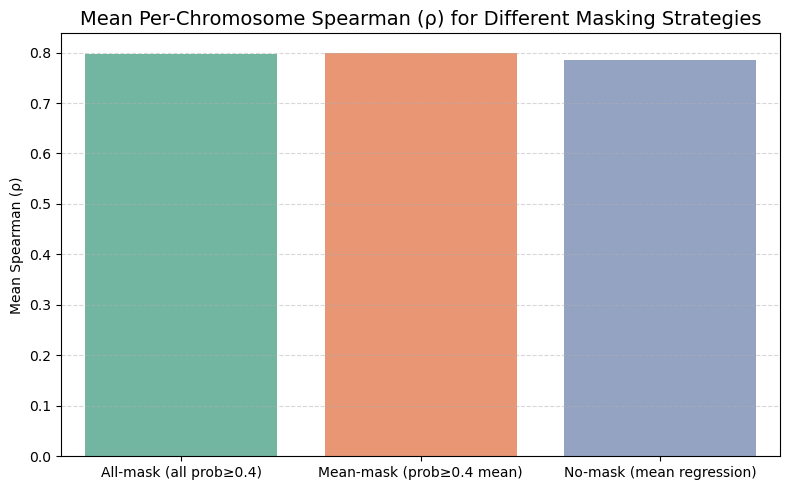

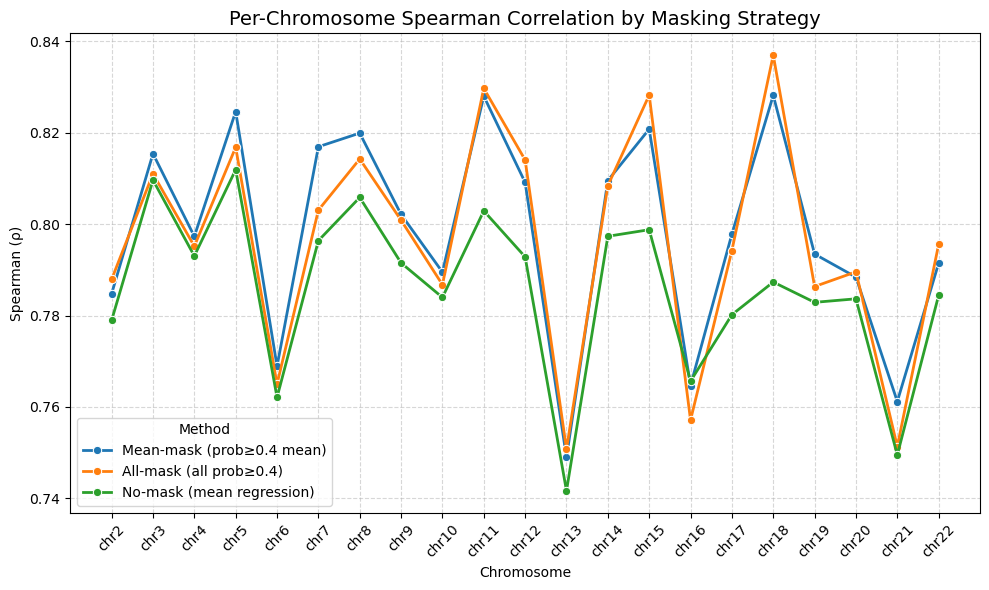


🌟 Best method = Mean-mask (prob≥0.4 mean) with mean Spearman ρ = 0.7981


In [27]:
# ============================================================
# 📊 Visualization: Mean per-chromosome Spearman (3 Mask Methods)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- Melt results for plotting ---
plot_df = results_df.melt(id_vars="chr",
                          value_vars=["rho_mean", "rho_all", "rho_none"],
                          var_name="Method",
                          value_name="Spearman_ρ")

# --- Rename methods for clearer legend ---
plot_df["Method"] = plot_df["Method"].replace({
    "rho_mean": "Mean-mask (prob≥0.4 mean)",
    "rho_all": "All-mask (all prob≥0.4)",
    "rho_none": "No-mask (mean regression)"
})

# --- Calculate mean per method ---
mean_df = plot_df.groupby("Method", as_index=False)["Spearman_ρ"].mean()

# --- Draw line/bar plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_df, x="Method", y="Spearman_ρ", palette="Set2")
plt.title("Mean Per-Chromosome Spearman (ρ) for Different Masking Strategies", fontsize=14)
plt.ylabel("Mean Spearman (ρ)")
plt.xlabel("")
plt.grid(True, linestyle="--", alpha=0.5, axis="y")
plt.tight_layout()
plt.show()

# ============================================================
# 📈 Optional: per-chromosome trend line
# ============================================================
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x="chr", y="Spearman_ρ", hue="Method", marker="o", linewidth=2)
plt.title("Per-Chromosome Spearman Correlation by Masking Strategy", fontsize=14)
plt.xlabel("Chromosome")
plt.ylabel("Spearman (ρ)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Print best performing method ---
best_method = mean_df.loc[mean_df["Spearman_ρ"].idxmax()]
print(f"\n🌟 Best method = {best_method['Method']} with mean Spearman ρ = {best_method['Spearman_ρ']:.4f}")
